In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import os

# Load data

data_path = os.path.join("..", "data", "Nifty50_Train.csv")
data = pd.read_csv(data_path)
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Add Simple Moving Average (SMA)
data['SMA_10'] = data['Close'].rolling(window=10).mean()

# Add Relative Strength Index (RSI)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff(1)
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

data['RSI_14'] = calculate_rsi(data)

# Fill missing values from SMA & RSI calculation
data.fillna(method='bfill', inplace=True)

# Normalize all features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data[['Close', 'SMA_10', 'RSI_14']])
scaled_data = pd.DataFrame(scaled_data, columns=['Close', 'SMA_10', 'RSI_14'], index=data.index)

# Function to create sequences
def create_sequences(data, seq_length):
    sequences, labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data.iloc[i:i+seq_length].values)
        labels.append(data.iloc[i+seq_length]["Close"])
    return np.array(sequences), np.array(labels)

sequence_length = 30
X, y = create_sequences(scaled_data, sequence_length)

# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


<ipython-input-1-11c84ca53528>:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='bfill', inplace=True)


In [ ]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 6.0 MB/s eta 0:00:00


In [ ]:
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Define model for tuning
def build_model(hp):
    model = Sequential([
        SimpleRNN(
            hp.Int('rnn_units', min_value=32, max_value=128, step=16),
            activation='relu',
            return_sequences=True,
            input_shape=(X_train.shape[1], X_train.shape[2])
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        SimpleRNN(
            hp.Int('rnn_units_2', min_value=32, max_value=128, step=16),
            activation='relu'
        ),
        Dropout(hp.Float('dropout_rate', min_value=0.1, max_value=0.5, step=0.1)),
        Dense(1)
    ])
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='mean_squared_error'
    )
    return model

# Define tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='rnn_tuning',
    project_name='stock_price'
)

# Perform hyperparameter search
tuner.search(X_train, y_train, epochs=20, validation_data=(X_test, y_test), batch_size=32)

# Get best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
Best RNN units: {best_hps.get('rnn_units')}
Best Dropout rate: {best_hps.get('dropout_rate')}
Best Learning rate: {best_hps.get('learning_rate')}
""")

# Train best model
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test))


Trial 10 Complete [00h 00m 40s]
val_loss: 0.002568671712651849

Best val_loss So Far: 0.00018290287698619068
Total elapsed time: 00h 07m 02s

Best RNN units: 128
Best Dropout rate: 0.1
Best Learning rate: 0.001

Epoch 1/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 0.0070 - val_loss: 0.0038
Epoch 2/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0019 - val_loss: 9.4373e-04
Epoch 3/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0012 - val_loss: 4.8372e-04
Epoch 4/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 1.4735e-04
Epoch 5/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.4202e-04 - val_loss: 4.0276e-04
Epoch 6/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 9.1797e-04 - val_loss: 8.9664e-04
Epoch 7/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - loss: 8.2907e-04 - val_loss: 8.1155e-04
Epoch 8/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 7.6333e-04 - val_loss: 5.8379e-04
Epoch 9/50
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.096

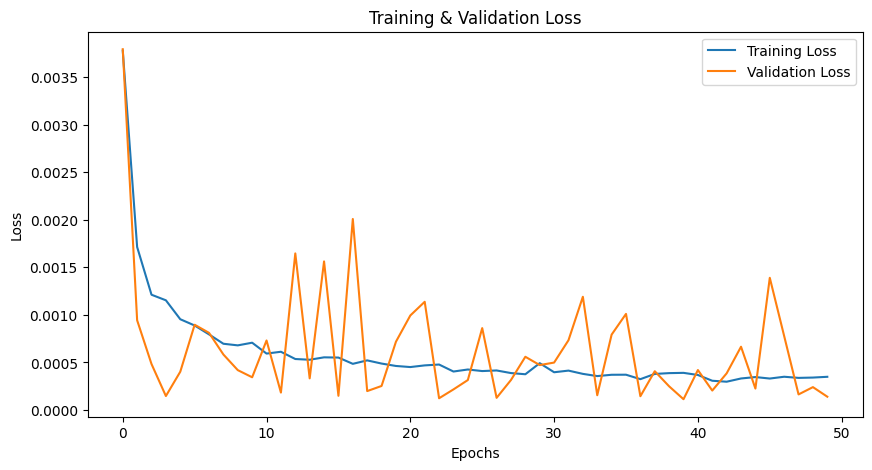

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training & Validation Loss')
plt.legend()
plt.show()


In [ ]:
# Make predictions
predicted = best_model.predict(X_test)

# Inverse transform predictions and actual values for better interpretation
scaler = MinMaxScaler()
scaler.fit(data[['Close', 'SMA_10', 'RSI_14']])  # Fit on original scale
predicted = scaler.inverse_transform(np.column_stack((predicted, np.zeros((predicted.shape[0], 2)))))[:, 0]
y_test_actual = scaler.inverse_transform(np.column_stack((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], 2)))))[:, 0]


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


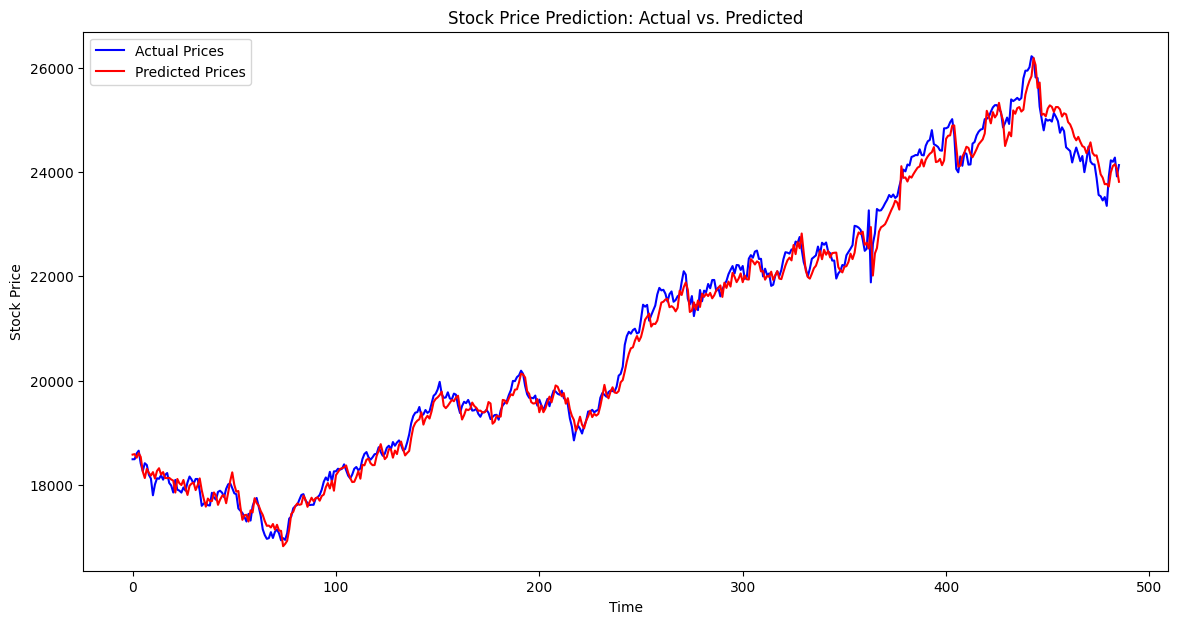

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test_actual, label='Actual Prices', color='blue')
plt.plot(predicted, label='Predicted Prices', color='red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction: Actual vs. Predicted')
plt.legend()
plt.show()


In [ ]:
# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
# Use the correct variable names: y_test_actual and predicted
mae = mean_absolute_error(y_test_actual, predicted)
rmse = np.sqrt(mean_squared_error(y_test_actual, predicted))
print(f"Optimized MAE: {mae:.4f}, Optimized RMSE: {rmse:.4f}")

Optimized MAE: 180.4257, Optimized RMSE: 228.0501
